In [ ]:
import pandas as pd
import numpy as np
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import random
import numpy as np
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score
import matplotlib.pyplot as plt
!pip install pmdarima

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Product Tide Detergent

# Data importation

In [ ]:
df=pd.read_csv("C:\\Users\\abhis\\Downloads\\Project\\predicted_sentiment (1).csv")
backup=df.copy()

In [ ]:
df = df.loc[df['asin'] == "B0037KMI0U"]

In [ ]:
df.head(5)

,Unnamed: 0,index,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,category,sentiment
488087,488087,191750,A1YVYAWW40VZL8,B0037KMI0U,1,"[0, 0]","rememb may year ago, ex wife alway wate buy ti...",5,"Its Tide, what's not to love.",1378080000,"09 2, 2013",Health and personal care,3
488088,488088,191751,A2D4FQHV506EPB,B0037KMI0U,319,"[1, 1]","husba, two small chilr sesit ski typic react h...",5,Clean subtle scent and super soft laundry,1402876800,"06 16, 2014",Health and personal care,3
488089,488089,191752,A2E1EFNIZL2FVA,B0037KMI0U,&#9899; RIZZO &#9899;,"[0, 0]",use tie year alway like way cloth come clea; o...,5,An all-time favorite product that always cleans!,1278374400,"07 6, 2010",Health and personal care,4
488090,488090,191753,ATFYRBOBGCQBK,B0037KMI0U,a80bean,"[0, 0]",like size bottl easi carri ow stair lauri mat ...,5,Good Deal.,1388361600,"12 30, 2013",Health and personal care,3
488091,488091,191754,A4QXTN3K865NR,B0037KMI0U,"aar! ""aar!""","[1, 2]","maufacturer, state &#34;tie col water - switch...",5,Tide Coldwater Clean Results in a Better Wash!,1400025600,"05 14, 2014",Health and personal care,3


In [ ]:
# df=df[df["category"]=="Health and personal care"]

In [ ]:
df["category"].unique()

array(['Health and personal care'], dtype=object)

Time Series

In [ ]:
df.drop(["overall","unixReviewTime", "Unnamed: 0"], inplace= True, axis = 1)

In [ ]:
df["reviewTime"] = pd.to_datetime(df["reviewTime"])
df = df.set_index('reviewTime')

In [ ]:
df = df.resample("Q").mean()

In [ ]:
df

,index,sentiment
reviewTime,,
2010-06-30,192355.850000,3.912500
2010-09-30,192382.090909,3.727273
2010-12-31,192838.000000,3.000000
2011-03-31,192581.000000,4.000000
2011-06-30,191904.000000,3.000000
2011-09-30,191855.000000,3.000000
2011-12-31,192435.428571,3.714286
2012-03-31,192219.000000,3.333333
2012-06-30,192184.666667,3.000000


In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# decomposition=seasonal_decompose(df["Very Satisfied"],period=4)
# d_trend=decomposition.trend
# d_seasonality=decomposition.seasonal
# d_residual=decomposition.resid
# import matplotlib.pyplot as plt
# decomposition.plot()
# plt.show()

# Decomposition of data 

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition=seasonal_decompose(df['sentiment'],period=4)
d_trend=decomposition.trend
d_seasonality=decomposition.seasonal
d_residual=decomposition.resid

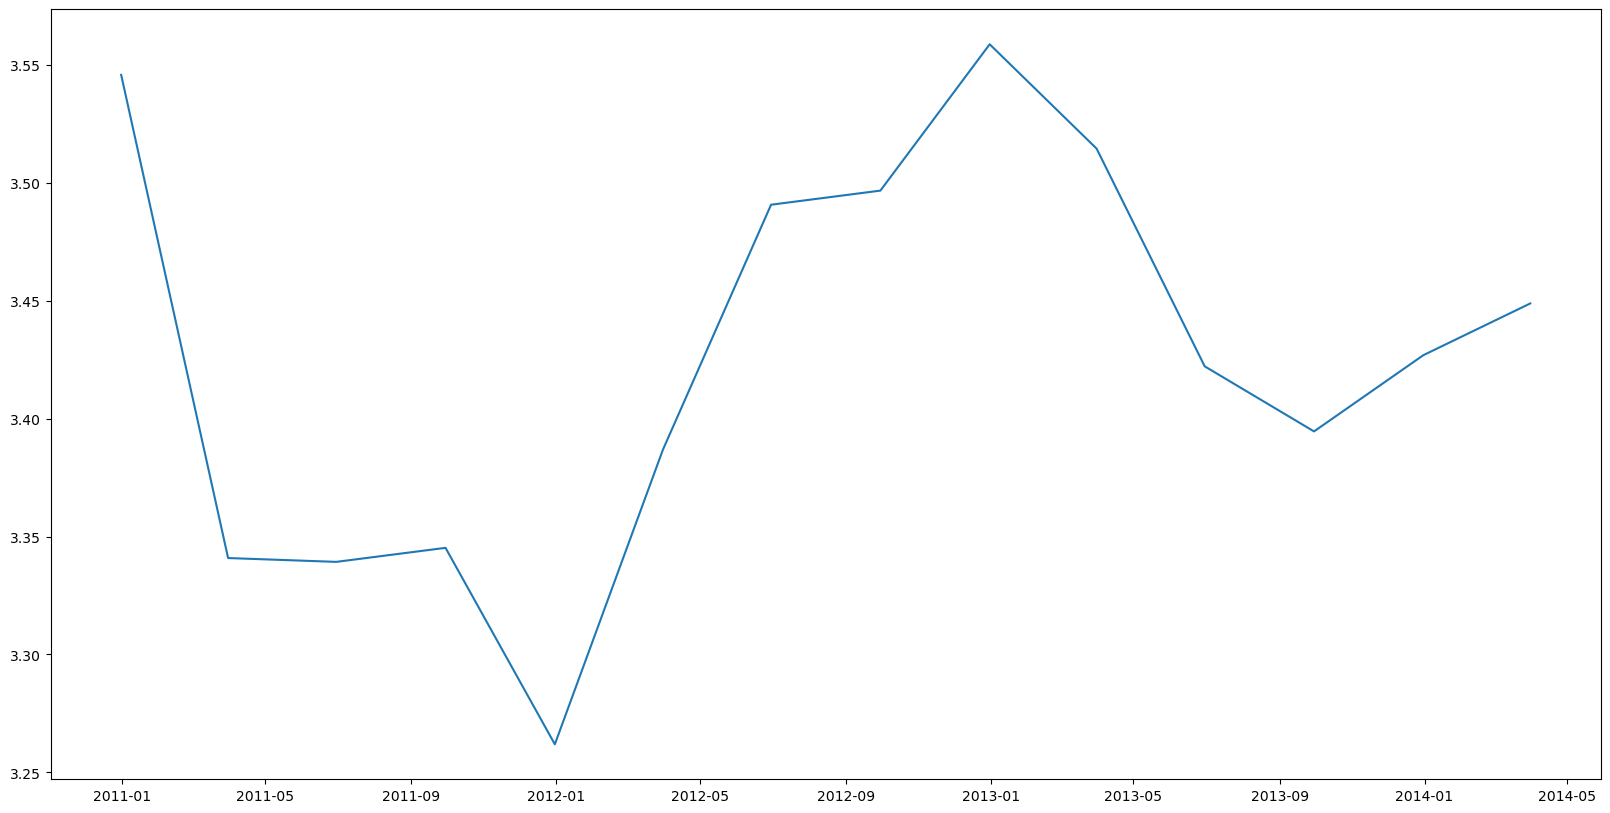

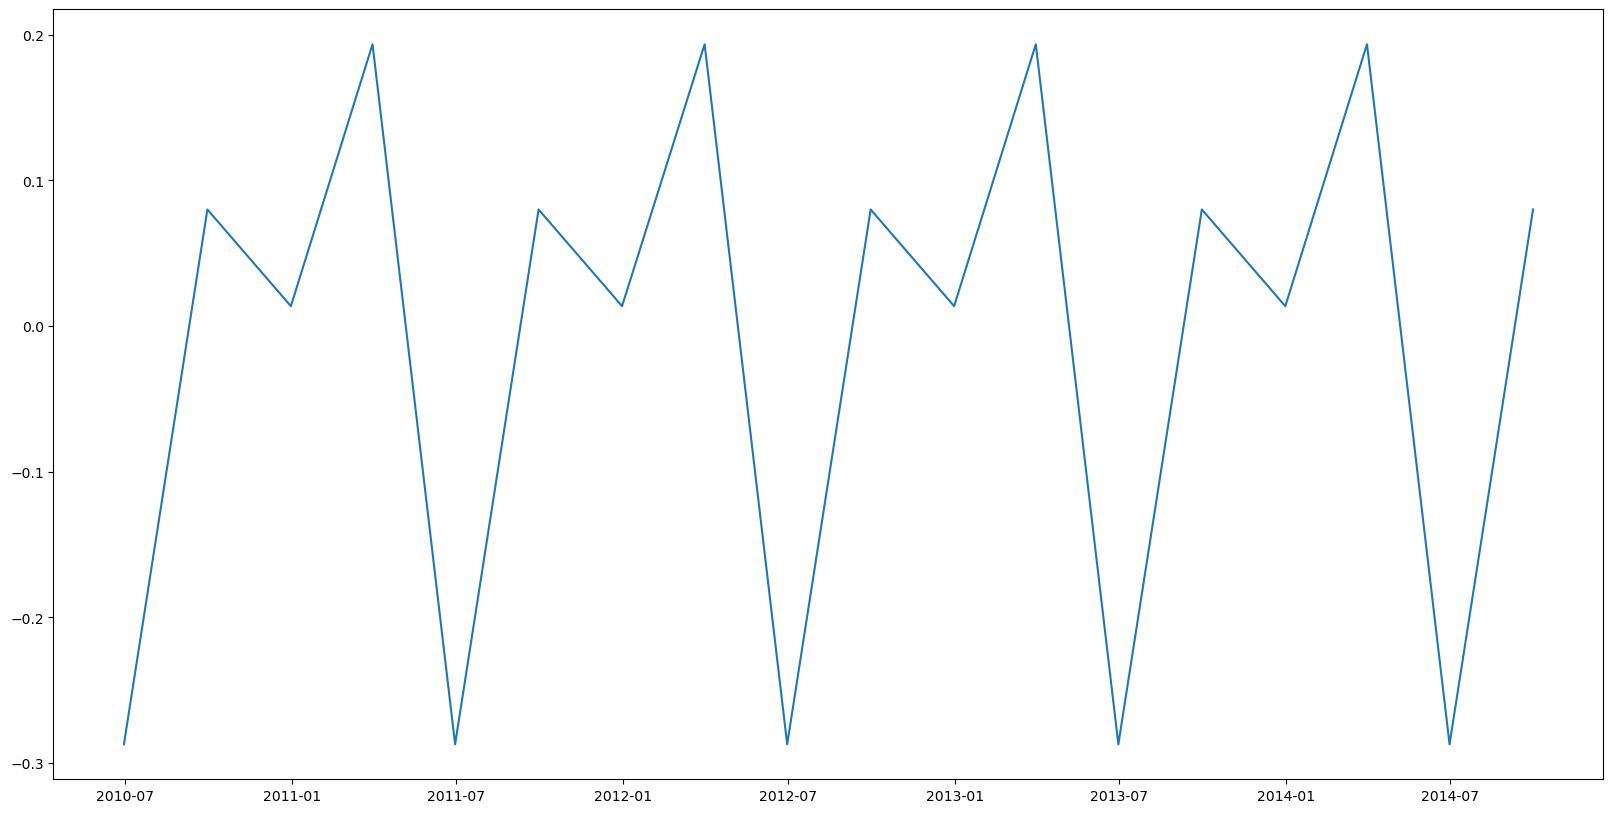

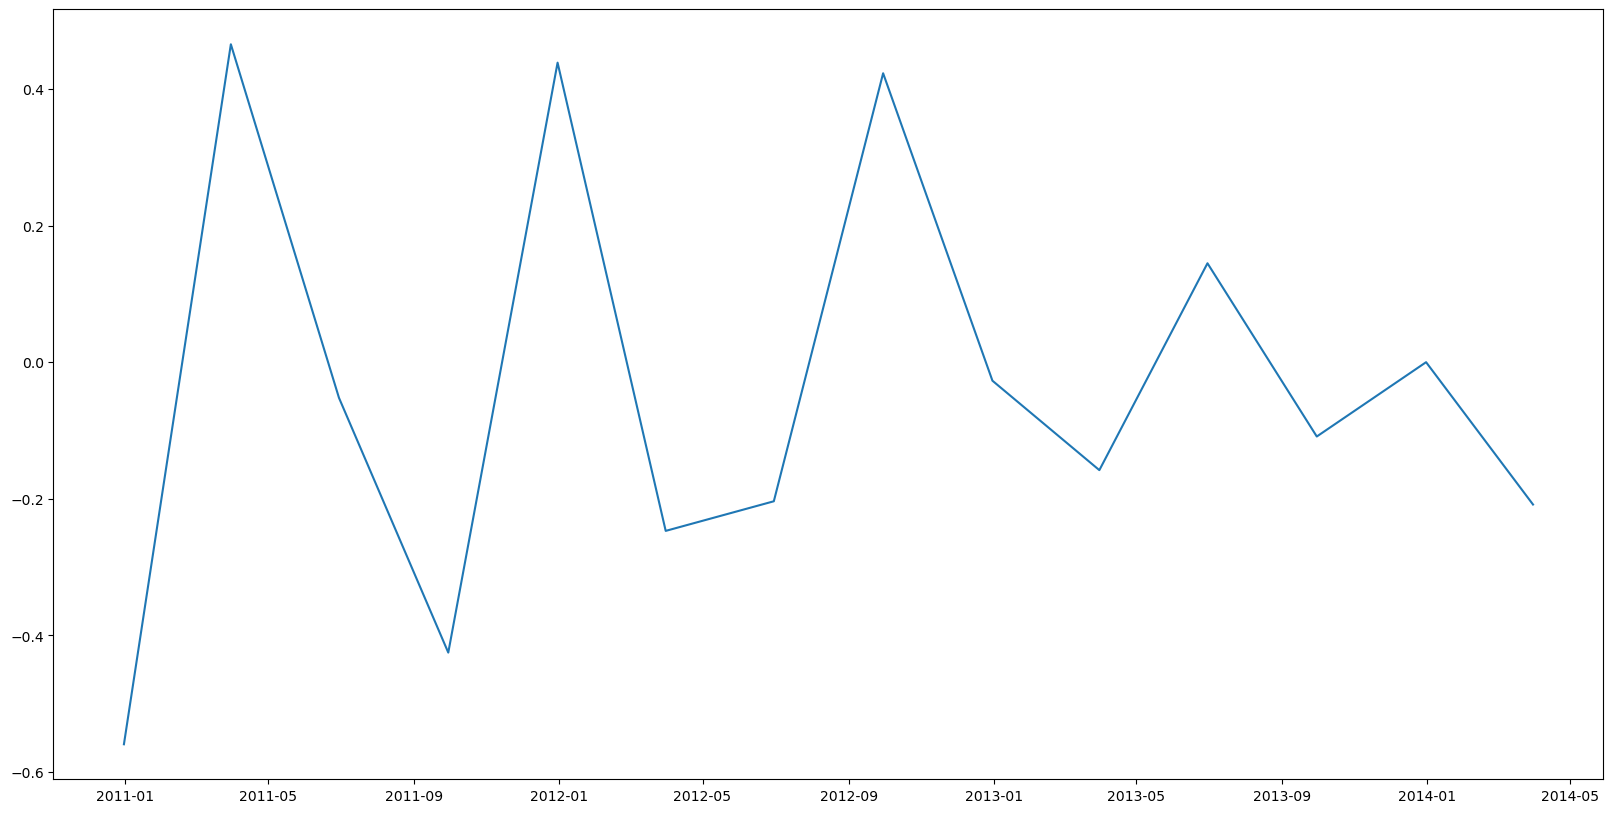

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(d_trend)
plt.figure(figsize=(20,10))
plt.plot(d_seasonality)
plt.figure(figsize=(20,10))
plt.plot(d_residual)

We can see from the above charts that the data has all 3 components trend seasonality and noise

### Checking Stationarity

In [ ]:
df = df['sentiment']

In [ ]:
# dickey-fuller test for stationarity
from statsmodels.tsa.stattools import adfuller
def checkStationarity(df):
    pvalue = adfuller(df)[1]
    
    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)
checkStationarity(df)

'p-value=6.967013636990567e-07. Data is stationary'

According to Adifuller data is stationary 

# Using Autoarima to find optimal parameters 

In [ ]:
from pmdarima.arima import auto_arima
df_new = auto_arima(df,start_p=0,max_p=5, start_q=0,max_q=5, seasonal=True, trace=True)
print(df_new.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=15.231, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=15.024, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=97.842, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=13.864, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=14.828, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=14.738, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=16.531, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.477 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   18
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  -2.932
Date:       

Auto arima gives us an optimal p,d,q values of (0,0,0) value

# Building sarima model

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

In [ ]:
len(df)

18

In [ ]:
train = df.iloc[:10]
test = df.iloc[10:]
print("train = {}, test = {}".format(len(train), len(test)))

train = 10, test = 8


In [ ]:
p=2; d=0; q=0
model = sm.tsa.statespace.SARIMAX(train,order=(p,d,q),seasonal_order=(p,d,q,4)).fit()
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         sentiment   No. Observations:                   10
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 4)   Log Likelihood                  -9.266
Date:                           Tue, 03 Jan 2023   AIC                             28.532
Time:                                   11:46:11   BIC                             30.045
Sample:                               06-30-2010   HQIC                            26.872
                                    - 09-30-2012                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0032     25.517      0.000      1.000     -50.009      50.016
ar.L2          0.9968     25.578      0.039

C:\Users\abhis\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [ ]:
start = len(train)
stop = len(train)+len(test)-1

In [ ]:
predictions = model.predict(start,stop,dynamic=True)
print("predictions", predictions)

predictions 2012-12-31    2.854568
2013-03-31    3.236821
2013-06-30    3.908226
2013-09-30    3.242790
2013-12-31    3.417816
2014-03-31    4.033247
2014-06-30    2.576749
2014-09-30    3.361965
Freq: Q-DEC, Name: predicted_mean, dtype: float64


In [ ]:
df_res = pd.DataFrame({'actual':df[9:],'predicted':predictions})
df_res['err'] = df_res.actual - df_res.predicted
df_res.dropna(inplace=True)
print(df_res)

              actual  predicted       err
2012-12-31  3.545455   2.854568  0.690886
2013-03-31  3.550000   3.236821  0.313179
2013-06-30  3.280000   3.908226 -0.628226
2013-09-30  3.365854   3.242790  0.123064
2013-12-31  3.440678   3.417816  0.022861
2014-03-31  3.433962   4.033247 -0.599284
2014-06-30  3.654762   2.576749  1.078013
2014-09-30  3.166667   3.361965 -0.195299


In [ ]:
msg = 'ARMA Model. Order=(' + str(0) + ',' + str(0) + ')'
mse1 = mean_squared_error(test,predictions )
print(msg + "\n\tMSE = {}\n\tRMSE = {}".format(mse1,np.sqrt(mse1)))

ARMA Model. Order=(0,0)
	MSE = 0.3181418331045534
	RMSE = 0.5640406307213633


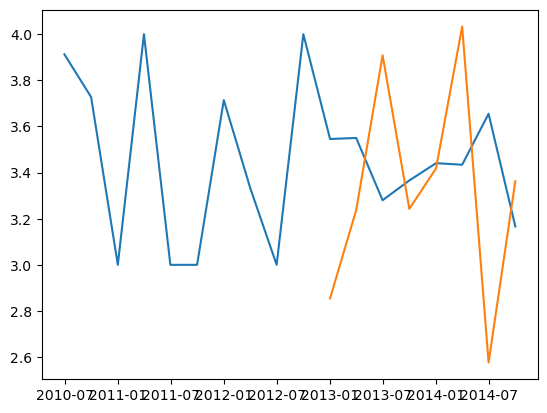

In [ ]:
plt.plot(df)
plt.plot(predictions)

In [ ]:
model = sm.tsa.statespace.SARIMAX(df,order=(p,d,q),seasonal_order=(p,d,q,4)).fit()

C:\Users\abhis\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [ ]:
forecast = model.forecast(10)

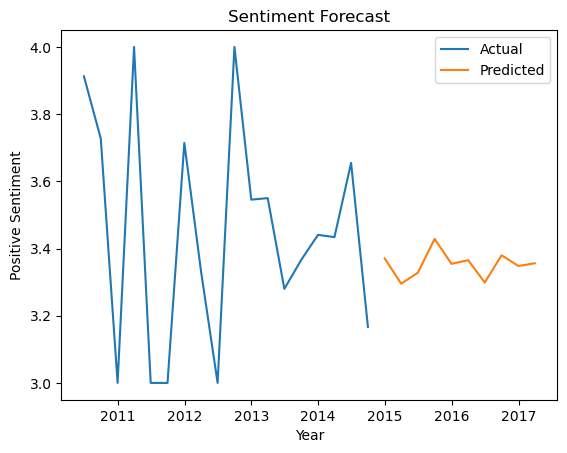

In [ ]:
plt.plot(df)
plt.xlabel("Year")
plt.ylabel("Positive Sentiment")
plt.title('Sentiment Forecast')
plt.plot(forecast)
plt.legend(['Actual','Predicted'])
plt.show()